# Compute the Aerobic Safety Margin

The Aerobic Saftey Margin (ASM) is defined as the maximum viable temperature for metabolism given the joint constraints of temperature and oxygen. 

We use the CESM-LE to define a linear relationship between projected changes in $P_{\mathrm{O}_2}$ and temperature under a climate warming scenario (RCP8.5). This relationship is used to compute the maximum viable temperature, which is the intersection of this linear relationship with the $P_{\mathrm{O}_2}\left|_{\Phi=1}\right.$ curve in $P_{\mathrm{O}_2}$-T space. This constraint can be computed on the basis of either resting (i.e., $P_{\mathrm{O}_2}\left|_{\Phi=1}\right.$) or active (i.e., $P_{\mathrm{O}_2}\left|_{\Phi=\Phi_{crit}}\right.$) metabolism.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product

import constants
import dask
import data_collections as dc
import funnel
import intake
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import operators as ops
import pop_tools
import regrid_tools
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Load CESM-LE trends

The relationship between $P_{\mathrm{O}_2}$ and temperature was precomputed in [this notebook](compute-trends-cesm-le.ipynb). Here we're using `funnel` to generate a data-catalog and load these data into an `xarray.Dataset`.


In [3]:
sub_spec = dict(
    name='drift-corrected.ann',
    experiment=['20C+RCP85'],
    member_id=dc.ocean_bgc_member_ids[0:2],
)

catalog_joined = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog_joined

,unique
experiment,1
component,1
stream,1
member_id,2
variable,1
name,1
path,2


In [4]:
dsets = catalog_joined.to_dataset_dict()
assert set(dsets.keys()) == {'20C+RCP85.ocn.pop.h.drift-corrected.ann'}
_, ds = dsets.popitem()
ds = ds.compute()
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:          (nlat: 384, nlon: 320, beta: 2, z_t: 40, member_id: 2)
Coordinates:
    KMT              (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    REGION_MASK      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    TAREA            (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    TLAT             (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG            (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
  * beta             (beta) int64 0 1
    dz               (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * nlat             (nlat) int64 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
  * nlon             (nlon) int64 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
  * z_t              (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * member_id        (member_id) int64 2 9
Data variables:
    pO2_v_TEMP_beta  (member_id, beta, z_t, nlat, nlon) float64 nan nan ... nan
Attributes: (12/14)
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    NCO:                       4.3.4
    contents:                  Diagnostic and Prognostic Variables
    ...                        ...
    intake_esm_varname:        ['pO2_v_TEMP_beta']
    tavg_sum_qflux:            2592000.0
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nco_openmp_thread_number:  1
    tavg_sum:                  2592000.0
    intake_esm_dataset_key:    20C+RCP85.ocn.pop.h.drift-corrected.ann

### Annual-means

For the purposes of illustration, also load some of the annual-mean data from the CESM-LE.

In [5]:
sub_spec = dict(
    name='drift-corrected.ann',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[0:2],
    variable=['pO2', 'TEMP'],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)

exp_keys = [
    f'20C.ocn.pop.h.drift-corrected.ann',
    f'RCP85.ocn.pop.h.drift-corrected.ann',
]
dsets = catalog.to_dataset_dict()
assert set(dsets.keys()) == set(exp_keys)

ds_ann = xr.concat([dsets[k] for k in exp_keys], dim='time', coords='minimal', compat='override')
ds_ann = ds_ann.drop(['ULAT', 'ULONG'])
ds_ann


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


,Array,Chunk
Bytes,13.26 GiB,9.38 MiB
Shape,"(2, 181, 40, 384, 320)","(1, 1, 10, 384, 320)"
Count,5796 Tasks,1448 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,13.26 GiB,9.38 MiB
Shape,"(2, 181, 40, 384, 320)","(1, 1, 10, 384, 320)"
Count,5796 Tasks,1448 Chunks
Type,float64,numpy.ndarray


## Compute ensemble-mean relationships

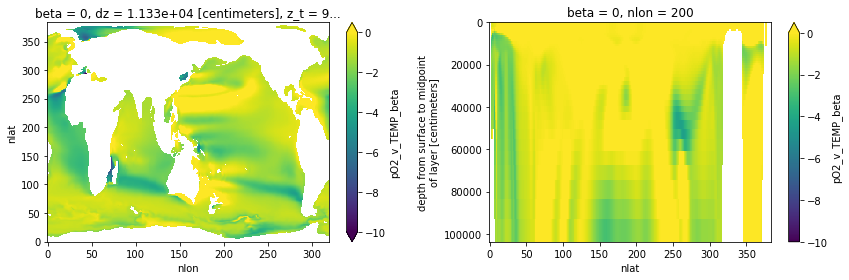

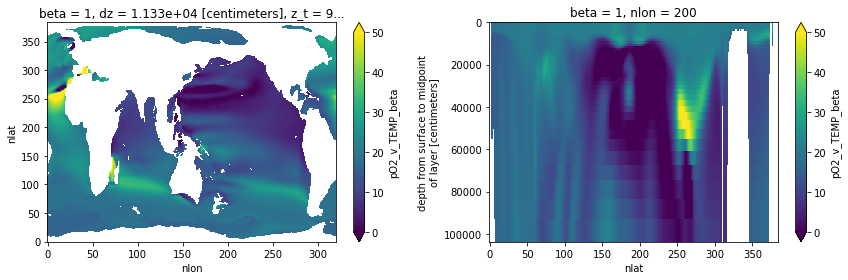

In [6]:
slope = ds.pO2_v_TEMP_beta.isel(beta=0).mean('member_id')
intercept = ds.pO2_v_TEMP_beta.isel(beta=1).mean('member_id')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
slope.isel(z_t=-1).plot(ax=axs[0], vmin=-10, vmax=0)
slope.isel(nlon=200).plot(ax=axs[1], vmin=-10, vmax=0, yincrease=False)
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
intercept.isel(z_t=-1).plot(ax=axs[0], vmin=0, vmax=50)
intercept.isel(nlon=200).plot(ax=axs[1], vmin=0, vmax=50, yincrease=False)
plt.tight_layout();

What is the distribution of the parameters defining the linear relationship between $P_{\mathrm{O}_2}$ and temperature?

Here we plot a histogram of the slope and intercept at 1000 m depth.

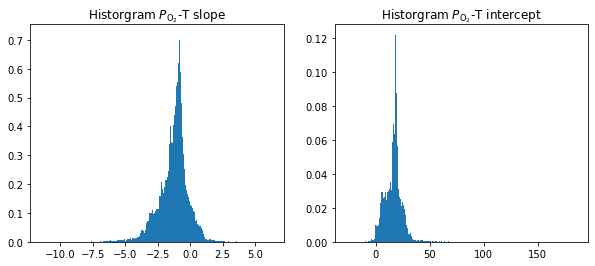

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(slope.isel(z_t=-1).values.ravel(), 300, density=True)
axs[0].set_title(r'Historgram $P_{\mathrm{O}_2}$-T slope')

axs[1].hist(intercept.isel(z_t=-1).values.ravel(), 300, density=True)
axs[1].set_title(r'Historgram $P_{\mathrm{O}_2}$-T intercept');

## Illustrate the ASM computation
Now, pick some representative locations with different values of the $P_{\mathrm{O}_2}$-T slope; get the intercept and annual-mean timeseries at these places.

In [8]:
slope_values = np.nanpercentile(slope, [5, 50, 95], interpolation='nearest')
intercept_values = np.empty(slope_values.shape)

pO2_ts = []
T_ts = []
for n, s in enumerate(slope_values):
    k, j, i = np.where(slope == s)
    intercept_values[n] = intercept.data[k, j, i]
    pO2_ts.append(ds_ann.pO2.isel(z_t=k, nlat=j, nlon=i).squeeze().compute())
    T_ts.append(ds_ann.TEMP.isel(z_t=k, nlat=j, nlon=i).squeeze().compute())

Make a figure showing the $P_{\mathrm{O}_2}$-at-$\Phi_{crit}$ curve for a representative ecotype (here we'll use the median traits); plot the linear $P_{\mathrm{O}_2}$-T relationship, $AT_{max}$, and the inferred Aerobic Safety Margin maximum temperature (`ASM_Tmax`).

`ASM_Tmax` is constrained to be less than or equal to $AT_{max}$.

In [9]:
df = mi.open_traits_df()
Ac = df.Ac.median()
Ao = df.Ao.median()
Eo = df.Eo.median()

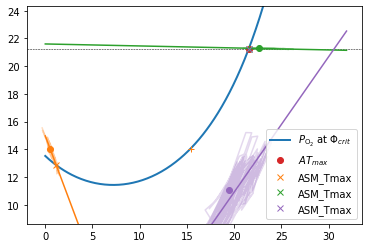

In [10]:
fig, ax = plt.subplots()

PO2_atm = constants.XiO2 * constants.kPa_per_atm

T = np.arange(0, 32, 0.1)

ax.axhline(PO2_atm, linewidth=0.5, color="k", linestyle="--")

ax.plot(
    T,
    mi.pO2_at_Phi_one(T, Ac, Eo, mi.dEodT_bar),
    "-",
    linewidth=2,
    label=r'$P_{\mathrm{O}_2}$ at $\Phi_{crit}$',
)

ATmax = mi.compute_ATmax(PO2_atm, Ac, Eo, mi.dEodT_bar)
ax.plot(
    ATmax,
    mi.pO2_at_Phi_one(ATmax, Ac, Eo, mi.dEodT_bar),
    marker="o",
    color="tab:red",
    label="$AT_{max}$",
    linestyle="none",
)

xlm = ax.get_xlim()
ylm = np.array(ax.get_ylim())
ylm[1] = PO2_atm + np.diff(ylm) * 0.05

colororder = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:pink",
    "tab:cyan",
    "tab:olive",
]

for n, (m, b) in enumerate(zip(slope_values, intercept_values)):
    for member_id in ds_ann.member_id.values:
        plt.plot(
            T_ts[n].sel(member_id=member_id),
            pO2_ts[n].sel(member_id=member_id),
            "-",
            color=colororder[n],
            alpha=0.25,
        )

    ASM_Tmax = mi.compute_ASM_Tmax(m, b, Ac, Eo, mi.dEodT_bar)

    Tmean = T_ts[n].sel(time=slice(1920, 1965)).mean(['time', 'member_id']).values
    pO2_mean = pO2_ts[n].sel(time=slice(1920, 1965)).mean(['time', 'member_id']).values

    const_pO2_Tmax = mi.compute_ATmax(
        pO2_mean,
        Ac,
        Eo,
        mi.dEodT_bar,
    )
    plt.plot(const_pO2_Tmax, pO2_mean, '+', color=colororder[n])

    plt.plot(
        Tmean,
        pO2_mean,
        "o",
        color=colororder[n],
    )

    plt.plot(
        T,
        m * T + b,
        "-",
        color=colororder[n],
    )

    plt.plot(
        ASM_Tmax,
        mi.pO2_at_Phi_one(ASM_Tmax, Ac, Eo, mi.dEodT_bar),
        "x",
        color=colororder[n],
        label="ASM_Tmax",
    )


ax.set_ylim(xlm)
ax.set_ylim(ylm)

plt.legend()

## Compute the ASM

Here we compute the ASM using the viable traits mask computed in [this notebook](compute-viable-traits.ipynb). Load that data here.

In [11]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_viability = cat['viable-traits-mask-cesm-1x1'].to_dask().load()
ds_viability

<xarray.Dataset>
Dimensions:            (Ac: 12, Eo: 11, Ao: 12, z_t: 40, lat: 180, lon: 360)
Coordinates:
  * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
  * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
  * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
    dz                 (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * z_t                (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
Data variables:
    ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 27.2 25.63 24.37
    ATmax_resting      (Ao, Eo) float64 42.49 35.22 29.01 ... 33.29 31.24 29.54
    Phi_active         (Ac, Eo, z_t, lat, lon) float64 nan nan ... 39.19 39.19
    Phi_resting        (Ao, Eo, z_t, lat, lon) float64 nan nan ... 129.0 129.0
    area               (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    trait_spc_active   (Ac, Eo) float64 0.0001004 0.0006727 ... 6.159e-06
    trait_spc_resting  (Ao, Eo) float64 0.0001098 0.0007361 ... 5.384e-06
    viability_active   (Ac, Eo, z_t, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    viability_resting  (Ao, Eo, z_t, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0

In [12]:
ds_epoch = cat['cesm-le-epoch-means'].to_dask().compute()
ds_epoch['TLAT'] = ds_epoch.TLAT[0, :, :]
ds_epoch['TLONG'] = ds_epoch.TLONG[0, :, :]
ds_epoch

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, epoch: 2, member_id: 32)
Coordinates:
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
  * epoch      (epoch) <U12 'ref_climate' '2100_climate'
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP       (epoch, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pO2        (epoch, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    NCO:                       4.3.4
    calendar:                  All years have exactly  365 days.
    cell_methods:              cell_methods = time: mean ==> the variable val...
    contents:                  Diagnostic and Prognostic Variables
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    ...                        ...
    nco_openmp_thread_number:  1
    nsteps_total:              750
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    source:                    CCSM POP2, the CCSM Ocean Component
    tavg_sum:                  2592000.0
    tavg_sum_qflux:            2592000.0

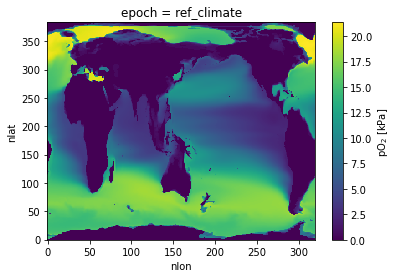

In [13]:
pO2_baseline = ds_epoch.pO2.sel(epoch='ref_climate')
pO2_baseline.plot()

In order to produce a trait-weighted, volume-weighted mean of ASM, here we regrid the CESM output to a regular lat-lon grid.

In [14]:
src_grid = regrid_tools.grid("POP_gx1v6")
dst_grid = regrid_tools.grid("latlon", nx=360, ny=180, lon0=-180.0)
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method="bilinear", clobber=False)
regrid_obj

exists: /glade/scratch/mclong/tmp/regridding/POP_gx1v6.nc
exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc
source grid dims: (384, 320)
destination grid dims: (180, 360)


regridder POP_gx1v6.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [15]:
ds_1x1 = regrid_tools.generate_latlon_grid(nx=360, ny=180, lon0=-180.0)[["area"]]
ds_1x1['z_t'] = ds.z_t
ds_1x1['dz'] = ds.dz

ds_1x1['slope'] = regrid_obj(slope, renormalize=True, apply_mask=True).rename(
    {'nlat': 'lat', 'nlon': 'lon'}
)
ds_1x1['intercept'] = regrid_obj(intercept, renormalize=True, apply_mask=True).rename(
    {'nlat': 'lat', 'nlon': 'lon'}
)
ds_1x1['pO2'] = regrid_obj(pO2_baseline, renormalize=True, apply_mask=True).rename(
    {'nlat': 'lat', 'nlon': 'lon'}
)

ds_1x1['vol'] = (ds_1x1.dz * ds_1x1.area).where(ds_1x1.slope.notnull())
for v in ds_viability.data_vars:
    ds_1x1[v] = ds_viability[v]

ds_1x1

<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360, z_t: 40, Ac: 12, Eo: 11, Ao: 12)
Coordinates:
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    dz                 (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * z_t                (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
  * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
  * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
  * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
Data variables: (12/13)
    area               (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    slope              (z_t, lat, lon) float64 nan nan nan ... 0.1972 0.1963
    intercept          (z_t, lat, lon) float64 nan nan nan ... 17.91 17.91 17.91
    pO2                (lat, lon) float64 nan nan nan nan ... 15.74 15.74 15.74
    vol                (z_t, lat, lon) float64 nan nan ... 1.223e+12 1.223e+12
    ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 27.2 25.63 24.37
    ...                 ...
    Phi_active         (Ac, Eo, z_t, lat, lon) float64 nan nan ... 39.19 39.19
    Phi_resting        (Ao, Eo, z_t, lat, lon) float64 nan nan ... 129.0 129.0
    trait_spc_active   (Ac, Eo) float64 0.0001004 0.0006727 ... 6.159e-06
    trait_spc_resting  (Ao, Eo) float64 0.0001098 0.0007361 ... 5.384e-06
    viability_active   (Ac, Eo, z_t, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    viability_resting  (Ao, Eo, z_t, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0

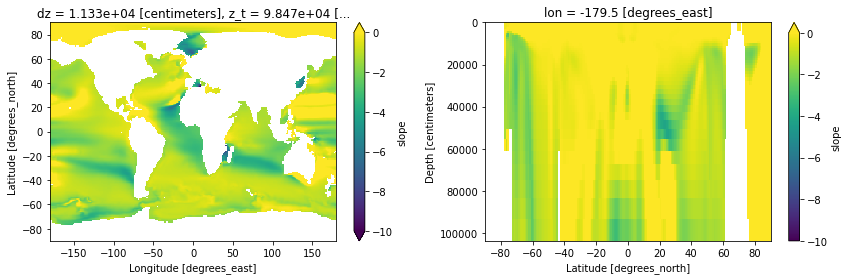

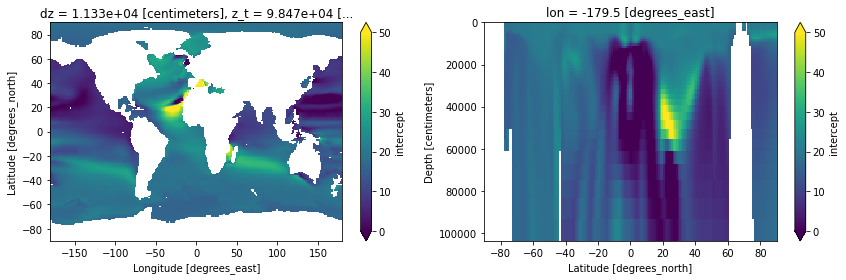

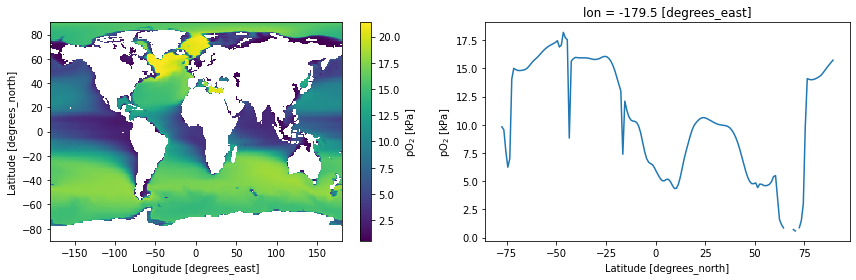

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ds_1x1.slope.isel(z_t=-1).plot(ax=axs[0], vmin=-10, vmax=0)
ds_1x1.slope.isel(lon=0).plot(ax=axs[1], vmin=-10, vmax=0, yincrease=False)
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ds_1x1.intercept.isel(z_t=-1).plot(ax=axs[0], vmin=0, vmax=50)
ds_1x1.intercept.isel(lon=0).plot(ax=axs[1], vmin=0, vmax=50, yincrease=False)
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ds_1x1.pO2.plot(ax=axs[0])
ds_1x1.pO2.isel(lon=0).plot(ax=axs[1])
plt.tight_layout();

### Compute the distribuion of `ASM_Tmax`

What is the distribution of ASM_Tmax as a function of latitude?

- The climate vector in $P_{\mathrm{O}_2}$-T space is computed for each grid cell (i, j, k);
- `ASM_Tmax` depends on the climate vector and the traits, $A_o$ (or $A_c$) and $E_o$.
- The occurence frequency of $A_o$ and $E_o$ trait combinations is described by the `trait_spc` PDF.
- The viability of particular traits varies geographically; the `viability` array stores this information.

Approach: 
1. Define ASM_Tmax bins;
1. At each latitude, within each ASM_Tmax bin, accumulate the frequency of traits


In [17]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='4GB')
    cluster.scale(200)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.58:45233,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [18]:
Tmax_bin_edge = np.arange(10, 64, 2)
Tmax_bin_c = np.vstack((Tmax_bin_edge[:-1], Tmax_bin_edge[1:])).mean(axis=0)
Tmax_bins = xr.DataArray(
    Tmax_bin_c,
    dims=('Tmax'),
    coords={'Tmax': Tmax_bin_c},
)
Tmax_bins

<xarray.DataArray (Tmax: 26)>
array([11., 13., 15., 17., 19., 21., 23., 25., 27., 29., 31., 33., 35.,
       37., 39., 41., 43., 45., 47., 49., 51., 53., 55., 57., 59., 61.])
Coordinates:
  * Tmax     (Tmax) float64 11.0 13.0 15.0 17.0 19.0 ... 55.0 57.0 59.0 61.0

In [19]:
ds_1x1_fut = ds_1x1.chunk({'lon': 10}).persist()

In [20]:
def _compute_const_pO2_Tmax(
    ds,
    i_trait,
    j_trait,
    hypoxic_tol,
    temp_sens,
    viability_mask_name,
):
    Ao = ds[hypoxic_tol].data[i_trait]
    Eo = ds[temp_sens].data[j_trait]

    viability = ds[viability_mask_name][i_trait, j_trait, :, :, :]

    const_pO2_Tmax = xr.full_like(ds.pO2, fill_value=np.nan)
    nk, nj, ni = ds.pO2.shape

    data = np.ones((nk, nj, ni)) * np.nan
    for k, j, i in product(range(nk), range(nj), range(ni)):
        if ~np.isnan(ds.pO2[k, j, i]) and viability[k, j, i] == 1.0:
            data[k, j, i] = mi.compute_ATmax(
                ds.pO2.data[k, j, i],
                Ac,
                Eo,
                mi.dEodT_bar,
            )
    const_pO2_Tmax.data = data
    return const_pO2_Tmax


def compute_const_pO2_Tmax(ds, i_trait, j_trait, hypoxic_tol, temp_sens, viability_mask_name):
    template = xr.full_like(ds.pO2, fill_value=np.nan)
    return xr.map_blocks(
        _compute_const_pO2_Tmax,
        ds,
        [i_trait, j_trait, hypoxic_tol, temp_sens, viability_mask_name],
        template=template,
    )

In [21]:
%%time
clobber = True

this_notebook = 'compute-aerobic-safety-margin.ipynb'

curator = util.curator_local_assets()

key = 'const-pO2-Tmax-1x1'

cache_file = f'{dc.cache_dir}/{key}.zarr'
os.makedirs(os.path.dirname(cache_file), exist_ok=True)

if not os.path.exists(cache_file) or clobber:

    dso = xr.Dataset()

    for v in ["trait_spc_active", "trait_spc_resting"]:

        # get trait space vars
        trait_space = ds_1x1[v]
        metabolic_baseline = trait_space.attrs["metabolic_baseline"]
        assert metabolic_baseline in ["active", "resting"]

        hypoxic_tol, temp_sens = trait_space.dims

        viability_mask_name = f"viability_{metabolic_baseline}"
        const_pO2_Tmax_varname = f"const_pO2_Tmax_{metabolic_baseline}"

        ni = len(trait_space[hypoxic_tol])
        nj = len(trait_space[temp_sens])

        # loop over trait space and lat bands, sum trait frequency
        da_list_outer = []
        for i_trait in range(ds_1x1.sizes[hypoxic_tol]):

            da_list_inner = []
            for j_trait in range(ds_1x1.sizes[temp_sens]):
                print('start func', end=':')
                with util.timer(f"func: {j_trait}, {i_trait}"):
                    da_list_inner.append(
                        compute_const_pO2_Tmax(
                            ds_1x1_fut,
                            i_trait,
                            j_trait,
                            hypoxic_tol,
                            temp_sens,
                            viability_mask_name,
                        ).persist()
                    )

            print('start concat', end=':')
            with util.timer(f"concat: {j_trait}"):
                da_list_outer.append(xr.concat(da_list_inner, dim=trait_space[temp_sens]))

        dso[const_pO2_Tmax_varname] = xr.concat(da_list_outer, dim=trait_space[hypoxic_tol])

    print('start write', end=':')
    with util.timer(f"write: {cache_file}"):
        dso.to_zarr(cache_file, mode='w', consolidated=True)

    print('done.')

    curator.add_source(
        key=key,
        urlpath=cache_file,
        description=f'constant pO2 maximum temperature {this_notebook}',
        driver='zarr',
        overwrite=True,
    )
else:
    cat = curator.open_catalog()
    dso = cat[key].to_dask().load()

dso

start func:[func: 0, 0]: 0.11375s
start func:[func: 1, 0]: 0.09518s
start func:[func: 2, 0]: 0.09588s
start func:[func: 3, 0]: 0.37248s
start func:[func: 4, 0]: 0.17337s
start func:[func: 5, 0]: 0.12475s
start func:[func: 6, 0]: 0.09890s
start func:[func: 7, 0]: 0.18776s
start func:[func: 8, 0]: 0.20000s
start func:[func: 9, 0]: 0.30256s
start func:[func: 10, 0]: 0.09616s
start concat:[concat: 10]: 0.00815s
start func:[func: 0, 1]: 0.24632s
start func:[func: 1, 1]: 0.19475s
start func:[func: 2, 1]: 0.10568s
start func:[func: 3, 1]: 0.09989s
start func:[func: 4, 1]: 0.09799s
start func:[func: 5, 1]: 0.24238s
start func:[func: 6, 1]: 0.10577s
start func:[func: 7, 1]: 0.10631s
start func:[func: 8, 1]: 0.10029s
start func:[func: 9, 1]: 0.09861s
start func:[func: 10, 1]: 0.09786s
start concat:[concat: 10]: 0.00826s
start func:[func: 0, 2]: 0.09889s
start func:[func: 1, 2]: 0.09694s
start func:[func: 2, 2]: 0.23695s
start func:[func: 3, 2]: 0.09804s
start func:[func: 4, 2]: 0.11282s
start fu

FileNotFoundError: [Errno 2] No such file or directory: '/glade/scratch/mclong/dask-workers/dask-worker-space/worker-sl8gw5cp/storage/%28%27Ac-_compute_const_pO2_Tmax-6b4a5a36d37e1f9a31cff13a987f215d-79c78008de0d2b9da8df2ff427d7fe61%27%2C%200%2C%200%2C%200%2C%200%2C%200%2C%200%29'

In [22]:
def _compute_ASM_Tmax(
    ds,
    i_trait,
    j_trait,
    hypoxic_tol,
    temp_sens,
    viability_mask_name,
):
    Ao = ds[hypoxic_tol].data[i_trait]
    Eo = ds[temp_sens].data[j_trait]

    viability = ds[viability_mask_name][i_trait, j_trait, :, :, :]

    ASM_Tmax = xr.full_like(ds.slope, fill_value=np.nan)
    nk, nj, ni = ds.slope.shape

    data = np.ones((nk, nj, ni)) * np.nan
    for k, j, i in product(range(nk), range(nj), range(ni)):
        if ~np.isnan(ds.slope[k, j, i]) and viability[k, j, i] == 1.0:
            data[k, j, i] = mi.compute_ASM_Tmax(
                ds.slope.data[k, j, i],
                ds.intercept.data[k, j, i],
                Ac,
                Eo,
                mi.dEodT_bar,
            )
    ASM_Tmax.data = data
    return ASM_Tmax


def compute_ASM_Tmax(ds, i_trait, j_trait, hypoxic_tol, temp_sens, viability_mask_name):
    template = xr.full_like(ds.slope, fill_value=np.nan)
    return xr.map_blocks(
        _compute_ASM_Tmax,
        ds,
        [i_trait, j_trait, hypoxic_tol, temp_sens, viability_mask_name],
        template=template,
    )

In [23]:
%%time
clobber = False

this_notebook = 'compute-aerobic-safety-margin.ipynb'

curator = util.curator_local_assets()

key = 'ASM-Tmax-1x1'

cache_file = f'{dc.cache_dir}/{key}.zarr'
os.makedirs(os.path.dirname(cache_file), exist_ok=True)

if not os.path.exists(cache_file) or clobber:

    dso = xr.Dataset()

    for v in ["trait_spc_active", "trait_spc_resting"]:

        # get trait space vars
        trait_space = ds_1x1[v]
        metabolic_baseline = trait_space.attrs["metabolic_baseline"]
        assert metabolic_baseline in ["active", "resting"]

        hypoxic_tol, temp_sens = trait_space.dims

        viability_mask_name = f"viability_{metabolic_baseline}"
        ASM_Tmax_varname = f"ASM_Tmax_{metabolic_baseline}"

        ni = len(trait_space[hypoxic_tol])
        nj = len(trait_space[temp_sens])

        # loop over trait space and lat bands, sum trait frequency
        da_list_outer = []
        for i_trait in range(ds_1x1.sizes[hypoxic_tol]):

            da_list_inner = []
            for j_trait in range(ds_1x1.sizes[temp_sens]):
                print('start func', end=':')
                with util.timer(f"func: {j_trait}, {i_trait}"):
                    da_list_inner.append(
                        compute_ASM_Tmax(
                            ds_1x1_fut,
                            i_trait,
                            j_trait,
                            hypoxic_tol,
                            temp_sens,
                            viability_mask_name,
                        ).persist()
                    )

            print('start concat', end=':')
            with util.timer(f"concat: {j_trait}"):
                da_list_outer.append(xr.concat(da_list_inner, dim=trait_space[temp_sens]))

        dso[ASM_Tmax_varname] = xr.concat(da_list_outer, dim=trait_space[hypoxic_tol])

    print('start write', end=':')
    with util.timer(f"write: {cache_file}"):
        dso.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key=key,
        urlpath=cache_file,
        description=f'ASM maximum temperature {this_notebook}',
        driver='zarr',
        overwrite=True,
    )
else:
    cat = curator.open_catalog()
    dso = cat[key].to_dask().load()

dso

KeyError: 'original-open_dataset-28b413e73494806757f3bb5bf75e97c5ASM_Tmax_resting-ab8897a93a2c2b3bfbb7ef3a191e5c02'

AttributeError: 'Dataset' object has no attribute 'ASM_Tmax_active'

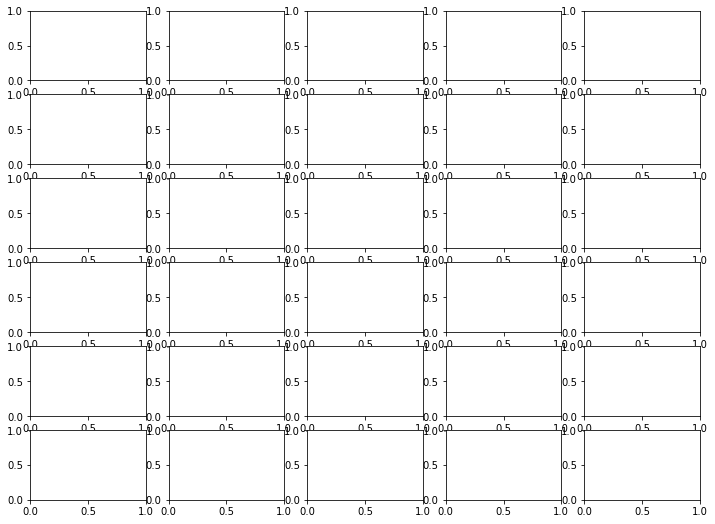

In [24]:
Eo = dso.Eo.values[1::2]  # [1, 3, 5]]
Ac = dso.Ac.values[::2]

fig, axs = plt.subplots(len(Ac), len(Eo), figsize=(12, 9))
for i, j in product(range(len(Ac)), range(len(Eo))):
    dso.ASM_Tmax_active.sel(Eo=Eo[j], Ac=Ac[i]).isel(lon=0).plot(
        yincrease=False,
        ax=axs[i, j],
        vmin=0,
        vmax=30,
    )

plt.tight_layout();

In [ ]:
if True:
    client.close()
    cluster.close()
    del client
    del cluster